In [1]:
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tools.numdiff import approx_hess1, approx_hess2, approx_hess3
import scipy.optimize as opt


In [2]:
class PoissonHMM(GenericLikelihoodModel):
    #endog:Yt; exog: X list of emission; k: #state; covariate:corvariate list of transtion matrix;
    #length: list of mutlti time serial data length, e.g. [15,22,30]; extra_params_names: name of parameters
    def __init__(self, endog, exog, k_regimes=2, covariate = None , length=None, loglike=None, score=None, hessian=None,
                 missing='none', extra_params_names=None, **kwds):
        super(PoissonHMM, self).__init__(endog=endog, exog=exog, loglike=loglike, score=score,
                                         hessian=hessian, missing=missing,
                                         extra_params_names=extra_params_names, kwds=kwds)
        #Initialize all variable

        self.y = np.array(self.endog)
        self.k_regimes = k_regimes
        if covariate is not None:
            self.covariate = np.array(covariate)
        if length is not None:
            self.length = np.array(length)
        else:
            self.length = None
        
        # 1 x (k_regimes-1) proxy of initial state probability matrix
        self.initial_state_matrix = np.ones([1, self.k_regimes-1])/k_regimes

        #k_regimes x corvariate.shape[1] size matrix of regime specific self-recurrent regression coefficients
        self.covariate_beta_matrix = np.ones([self.k_regimes, self.covariate.shape[1] ])

        # k x (k-2) matrix of psuedo transition probabilities which can range from -inf to +inf during
        # optimization. Initialized to 1.0/k-2
        if self.k_regimes>2:
            self.q_matrix = np.ones([self.k_regimes,(self.k_regimes-2)])*(1.0/ (self.k_regimes-2) )

        #k_regimes x exog.shape[1] size matrix of regime specific regression coefficients
        self.beta_matrix = np.ones([self.k_regimes, self.exog.shape[1]])

        #The regime wise matrix of Poisson means. These would be updated during the optimization
        # loop
        self.mu_matrix = []

        # (t-1) x k x k matrix of the real Markov transition probabilities which will be calculated from
        # the q-matrix using a standardization technique. Initialized to 1.0/k
        self.gamma_matrix = np.ones([self.exog.shape[0]-1, self.k_regimes, self.k_regimes])*(1.0/self.k_regimes)

        # The Markov state probabilities. Also referred to as pi. but we'll use delta since pi is
        # often used to refer to the mean
        self.delta_matrix = np.ones([self.exog.shape[0],self.k_regimes])*(1.0/self.k_regimes)

        #A very tiny number (machine specific). Used by the LL function.
        self.EPS = np.MachAr().eps

        #Optimization iteration counter
        self.iter_num=0

        #The vector of initial values for all the parameters, beta and q, that the optimizer will
        # optimize
        self.start_params = self.beta_matrix.flatten()
        self.start_params = np.append(self.start_params, self.initial_state_matrix.flatten())
        self.start_params = np.append(self.start_params, self.covariate_beta_matrix.flatten())

        if k_regimes>2:
            self.start_params = np.append(self.start_params, self.q_matrix.flatten())
        
        self.ll_history = np.zeros([1,1])
        self.params_history = np.zeros([1,len(self.start_params)])

    #This method is called by the optimizer once in each iteration to get the current value of
    # the log-likelihood corresponding to the current values of all the parameters.
    def nloglikeobs(self, params):
        #Reconstitute the q and beta matrices from the current values of all the params
        self.reconstitute_parameter_matrices(params)

        #Build the regime wise matrix of Poisson means
        self.compute_regime_specific_poisson_means()

        #Build the matrix of Markov transition probabilities by standardizing all the q values to
        # the 0 to 1 range
        self.compute_markov_transition_probabilities()

        #Build the (len(y) x k) matrix delta of Markov state probabilities distribution. k state
        # probabilities corresponding to k regimes, times, number of time steps (i.e. observations)
        self.compute_markov_state_probabilities()

        #Let's increment the iteration count
        self.iter_num=self.iter_num+1

        # Compute all the log-likelihood values for the Poisson Markov model
        ll = self.compute_loglikelihood()

        self.ll_history = np.append(self.ll_history, (ll.sum(0)).reshape([1,1]), axis=0)
        self.params_history = np.append(self.params_history, params.reshape([1,len(params)]), axis=0)

        

        #Print out the iteration summary
        print('ITER='+str(self.iter_num) + ' ll='+str(((-ll).sum(0))))

        #Return the negated array of  log-likelihood values
        return -ll
        
    #This method is called by the optimizer once in each iteration to get the current value of
    # the log-likelihood corresponding to the current values of all the parameters.
    def nloglikeopt(self, params):
        #Reconstitute the q and beta matrices from the current values of all the params
        self.reconstitute_parameter_matrices(params)

        #Build the regime wise matrix of Poisson means
        self.compute_regime_specific_poisson_means()

        #Build the matrix of Markov transition probabilities by standardizing all the q values to
        # the 0 to 1 range
        self.compute_markov_transition_probabilities()

        #Build the (len(y) x k) matrix delta of Markov state probabilities distribution. k state
        # probabilities corresponding to k regimes, times, number of time steps (i.e. observations)
        self.compute_markov_state_probabilities()

        #Let's increment the iteration count
        self.iter_num=self.iter_num+1

        # Compute all the log-likelihood values for the Poisson Markov model
        ll = self.compute_loglikelihood()

        #Print out the iteration summary
        print('ITER='+str(self.iter_num) + ' ll='+str(((-ll).sum(0))))

        self.ll_history = np.append(self.ll_history, (ll.sum(0)).reshape([1,1]), axis=0)
        self.params_history = np.append(self.params_history, params.reshape([1,len(params)]), axis=0)

        #Return the negated array of  log-likelihood values
        return -ll.sum()

    # Reconstitute the q and beta matrices from the current values of all the params
    def reconstitute_parameter_matrices(self, params):
        index = 0

        self.beta_matrix = params[ : self.k_regimes*self.exog.shape[1] ]
        self.beta_matrix = self.beta_matrix.reshape([self.k_regimes, self.exog.shape[1] ]) 
        index = index + self.k_regimes*self.exog.shape[1]
        
        self.initial_state_matrix = params[index : index + self.k_regimes - 1 ]
        self.initial_state_matrix = self.initial_state_matrix.reshape([1, self.k_regimes-1])
        index = index + self.k_regimes - 1

        self.covariate_beta_matrix = params[index : index + self.k_regimes * self.covariate.shape[1]]
        self.covariate_beta_matrix = self.covariate_beta_matrix.reshape([self.k_regimes, self.covariate.shape[1] ])
        index = index + self.k_regimes * self.covariate.shape[1]
            
        if k_regimes>2:
            self.q_matrix = params[index : index + self.k_regimes*(self.k_regimes-2)]
            self.q_matrix = self.q_matrix.reshape([self.k_regimes, (self.k_regimes-2)])

    # Build the regime wise matrix of Poisson means
    def compute_regime_specific_poisson_means(self):
        self.mu_matrix = []

        for j in range(self.k_regimes):
            #Fetch the regression coefficients vector corresponding to the jth regime
            beta_j = self.beta_matrix[j]

            #Compute the Poisson mean and variance
            mu_j = np.exp(self.exog.dot(beta_j))
 

            if len(self.mu_matrix) == 0:
                self.mu_matrix = mu_j
            else:
                self.mu_matrix = np.vstack((self.mu_matrix,mu_j))


                
        self.mu_matrix = self.mu_matrix.transpose()

    # Build the matrix of Markov transition probabilities by computing self-recurrent and non-recurrent state probabilities
    def compute_markov_transition_probabilities(self):
        
        # t x k recurrent matrix compute state k transition to itself in every time t
        self.recurrent_matrix = (self.covariate.dot(self.covariate_beta_matrix.transpose()))
        for t in range(self.exog.shape[0]-1):
            for i in range(self.k_regimes):
                for j in range(self.k_regimes):
                    if(i==j):
                        if(self.recurrent_matrix[t][j]>=709):
                            self.recurrent_matrix[t][j]=709
                        self.gamma_matrix[t][i][j] = math.exp(self.recurrent_matrix[t][j]) /( 1 + math.exp(self.recurrent_matrix[t][j]) )

        # If k=2, there's no need to use q_matrix
        if(self.k_regimes==2):
            for t in range(self.exog.shape[0]-1):
                for i in range(self.k_regimes):
                    for j in range(self.k_regimes):
                        if(i!=j):
                            self.gamma_matrix[t][i][j] = 1 - self.gamma_matrix[t][i][i]
        else:
            for t in range(self.exog.shape[0]-1):
                #Using  q to compute transtion probability which is not self-recurrent
                for i in range(self.k_regimes):
                    denom = 1
                    count = 0
                    for r in range(self.k_regimes-2):
                        denom += math.exp(self.q_matrix[i][r])
                        
                    for j in range(self.k_regimes):            
                        if(i==j ):continue
                        else:
                            if(count < self.k_regimes-2):
                                self.gamma_matrix[t][i][j] =( math.exp(self.q_matrix[i][count])/denom)*(1-self.gamma_matrix[t][i][i])
                                count+=1
                            else:
                                self.gamma_matrix[t][i][j] = (1.0/denom)*(1-self.gamma_matrix[t][i][i])

    # Build the (t x k) matrix delta of Markov state probabilities distribution. k state
    # probabilities corresponding to k regimes, times, number of time steps (i.e. observations)
    def compute_markov_state_probabilities(self):
        #Compute initial state probability
        denom = 1
        for r in range(self.k_regimes-1):
            if(self.initial_state_matrix[0][r]>709):
                self.initial_state_matrix[0][r] = 709
            denom += math.exp(self.initial_state_matrix[0][r])
            
        for j in range(k_regimes-1):
            self.delta_matrix[0][j] = math.exp(self.initial_state_matrix[0][j])/denom
        self.delta_matrix[0][k_regimes-1] = 1.0/denom

        #Compute state probabilties in each time t seperately if there's multiple time serial data.
        if(self.length is not None):
            index = 1
            for n in range(len(self.length)):
                for t in range(index, index + self.length[n] - 1):
                    self.delta_matrix[t] = np.matmul(self.delta_matrix[t-1], self.gamma_matrix[t-1])
                index += self.length[n]
                if (index-1) < len(self.y):
                    self.delta_matrix[index-1]= self.delta_matrix[0]
        else:
            for t in range(1, len(self.y)):
                self.delta_matrix[t] = np.matmul(self.delta_matrix[t-1], self.gamma_matrix[t-1])


    # Compute all the log-likelihood values for the Poisson Markov model
    def compute_loglikelihood(self):
        #Init the list of loglikelihhod values, one value for each y observation
        ll = []
        for t in range(len(self.y)):
            prob_y_t = 0
            mu_t = 0
            for j in range(self.k_regimes):
                #To use the law of total probability, uncomment this row and comment out the next
                # two rows
                prob_y_t += poisson.pmf(self.y[t], self.mu_matrix[t][j]) * self.delta_matrix[t][j]
                #Calculate the Poisson mean mu_t as an expectation over all Markov state
                # probabilities
                #mu_t += self.mu_matrix[t][j] * self.delta_matrix[t][j]
                #prob_y_t += poisson.pmf(self.y[t], mu_t)

            #This is a bit of a kludge. If the likelihood turns out to be real tiny, fix it to
            # the EPS value for the machine
            if prob_y_t < self.EPS:
                prob_y_t = self.EPS
            #Push the LL into the list of LLs
            ll.append(math.log(prob_y_t))
        ll = np.array(ll)
        return ll
    
    #Decode state path
    def decode(self):
        #decoded state path matrix: t
        self.decode_matrix = np.ones([len(self.y)])
        for t in range( len(self.y) ):
            max = 0
            state = 0
            for k in range(self.k_regimes):
                if(k == 0):
                    max = self.delta_matrix[t][k]
                    state = state + 1
                else:
                    if(self.delta_matrix[t][k] > max):
                        state = state + 1
                        max = self.delta_matrix[t][k]
            self.decode_matrix[t] = state

    #Sort beta_matrix, covariate_beta_matrix, delta_matrix, gamma_matrix and mu_matrix with k_state's emission intercept in ascending order 
    # using selection sort.
    def sort(self):
        for i in range(self.k_regimes-1):
            minimum = i
            for j in range(i+1,self.k_regimes):
                if( self.beta_matrix[minimum][0] > self.beta_matrix[j][0] ):
                    minimum = j
            if(minimum != i):
                self.beta_matrix = list(self.beta_matrix)
                self.beta_matrix[minimum], self.beta_matrix[i] =  self.beta_matrix[i], self.beta_matrix[minimum]
                self.beta_matrix = np.array(self.beta_matrix)

                self.covariate_beta_matrix = list(self.covariate_beta_matrix)
                self.covariate_beta_matrix[minimum], self.covariate_beta_matrix[i] = self.covariate_beta_matrix[i], self.covariate_beta_matrix[minimum]
                self.covariate_beta_matrix = np.array(self.covariate_beta_matrix)

                self.delta_matrix = list(self.delta_matrix)
                self.mu_matrix = list(self.mu_matrix)

                for t in range(len(self.y)):
                    self.delta_matrix[t][minimum], self.delta_matrix[t][i] =  self.delta_matrix[t][i], self.delta_matrix[t][minimum]
                    self.mu_matrix[t][minimum], self.mu_matrix[t][i] =  self.mu_matrix[t][i], self.mu_matrix[t][minimum]
                self.delta_matrix = np.array(self.delta_matrix)
                self.mu_matrix = np.array(self.mu_matrix)

                self.gamma_matrix = list(self.gamma_matrix) 
                for t in range(len(self.y)-1):
                    self.gamma_matrix[t][minimum][minimum], self.gamma_matrix[t][i][i] = self.gamma_matrix[t][i][i], self.gamma_matrix[t][minimum][minimum]
                    self.gamma_matrix[t][minimum][i], self.gamma_matrix[t][i][minimum] = self.gamma_matrix[t][i][minimum], self.gamma_matrix[t][minimum][i]
                self.gamma_matrix = np.array(self.gamma_matrix)

                
                

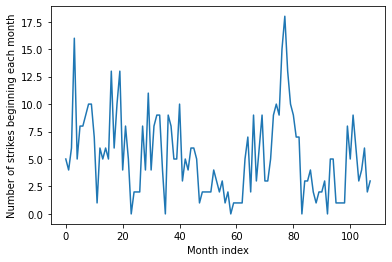

In [3]:
strikes_dataset = sm.datasets.get_rdataset(dataname="StrikeNb", package = "Ecdat")
strikes_data = strikes_dataset.data

#Plot the number of strikes starting each month
plt.xlabel('Month index')
plt.ylabel('Number of strikes beginning each month')
strikes_data['strikes'].plot()
plt.show()

In [4]:
strikes_data['strikes_lag1'] = strikes_data['strikes'].shift(1)
strikes_data = strikes_data.dropna()

def indicator_func(x):
    if x == 0:
        return 1
    else:
        return 0

strikes_data['d1'] = strikes_data['strikes_lag1'].apply(indicator_func)
strikes_data['strikes_adj_lag1']=np.maximum(1,strikes_data['strikes_lag1'])
strikes_data['ln_strike_adj_lag1']=np.log(strikes_data['strikes_adj_lag1']) 

expr = 'strikes ~ output + ln_strike_adj_lag1 + d1'
y_train, x_train = dmatrices(expr, strikes_data, return_type='dataframe')

C:\Users\s9421\AppData\Local\Temp/ipykernel_18800/3195480036.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strikes_data['d1'] = strikes_data['strikes_lag1'].apply(indicator_func)
C:\Users\s9421\AppData\Local\Temp/ipykernel_18800/3195480036.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strikes_data['strikes_adj_lag1']=np.maximum(1,strikes_data['strikes_lag1'])
C:\Users\s9421\AppData\Local\Temp/ipykernel_18800/3195480036.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [5]:
gen_poisson = sm.Poisson(y_train, x_train)


gen_poisson_results = gen_poisson.fit()


print(gen_poisson_results.summary())

Optimization terminated successfully.
         Current function value: 2.591103
         Iterations 5
                          Poisson Regression Results                          
Dep. Variable:                strikes   No. Observations:                  107
Model:                        Poisson   Df Residuals:                      103
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Jul 2022   Pseudo R-squ.:                  0.1283
Time:                        14:40:06   Log-Likelihood:                -277.25
converged:                       True   LL-Null:                       -318.05
Covariance Type:            nonrobust   LLR p-value:                 1.386e-17
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.8960      0.116      7.737      0.000       0.669       1.123
outpu

In [6]:
gen_poisson_results.aic

562.4960355639283

In [7]:
np.abs(gen_poisson_results.resid).mean()

2.466673404641672

In [8]:
p = np.exp(x_train.dot([0.8960, 2.3447, 0.4822, 0.5527]))

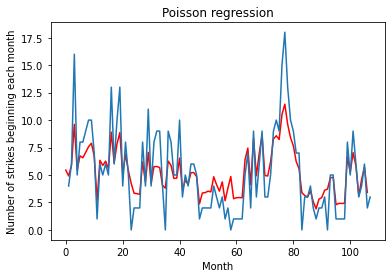

In [9]:
plt.xlabel('Month')
plt.ylabel('Poisson regression mean')
plt.title("Poisson regression")
plt.plot(range(107),p,'r')


#Plot the number of strikes starting each month
plt.xlabel('Month')
plt.ylabel('Number of strikes beginning each month')
strikes_data['strikes'].plot()
plt.show()

In [10]:
cor = 'strikes ~ output + ln_strike_adj_lag1 + d1 '
y, covariate = dmatrices(cor, strikes_data, return_type='dataframe')

In [11]:
covariate

,Intercept,output,ln_strike_adj_lag1,d1
1,1.0,0.00997,1.609438,0.0
2,1.0,0.01170,1.386294,0.0
3,1.0,0.00473,1.791759,0.0
4,1.0,0.01277,2.772589,0.0
5,1.0,0.01138,1.609438,0.0
...,...,...,...,...
103,1.0,0.00134,1.791759,0.0
104,1.0,-0.12810,1.098612,0.0
105,1.0,-0.01538,1.386294,0.0
106,1.0,-0.00703,1.791759,0.0


In [12]:
k_regimes = 2
extra_params_names = []

for regime_num in range(1, k_regimes):
    for param_name in x_train.columns:
        extra_params_names.append(param_name+'_R'+str(regime_num))

for k in range(k_regimes-1):
    extra_params_names.append('Initial state_'+str(k))

for regime_num in range(k_regimes):
#    extra_params_names.append("Intercept_"+str(regime_num))
    for param_name in covariate.columns:
        extra_params_names.append(param_name+"_"+str(regime_num))
    

#for i in range(k_regimes):
#    for j in range(k_regimes-2):
#        extra_params_names.append('q_'+str(i)+str(j))

In [13]:
extra_params_names

['Intercept_R1',
 'output_R1',
 'ln_strike_adj_lag1_R1',
 'd1_R1',
 'Initial state_0',
 'Intercept_0',
 'output_0',
 'ln_strike_adj_lag1_0',
 'd1_0',
 'Intercept_1',
 'output_1',
 'ln_strike_adj_lag1_1',
 'd1_1']

In [14]:
poisson_hmm = PoissonHMM(endog=y_train, exog=x_train, covariate=covariate,
                        k_regimes=k_regimes,length=[len(y_train)],
                        extra_params_names=extra_params_names)
params = poisson_hmm.start_params           
             
#res=opt.minimize(poisson_hmm.nloglikeopt,params, method='Nelder-Mead')

poisson_hmm_results = poisson_hmm.fit(method='bfgs', maxiter=400)

ITER=1 ll=743.7023233996701
ITER=2 ll=743.7023233996701
ITER=3 ll=743.703892780776
ITER=4 ll=743.7007539849504
ITER=5 ll=743.7023326767463
ITER=6 ll=743.7023141225152
ITER=7 ll=743.7054837977364
ITER=8 ll=743.6991628134526
ITER=9 ll=743.7023475640017
ITER=10 ll=743.702299235282
ITER=11 ll=743.7038210443277
ITER=12 ll=743.7008257210506
ITER=13 ll=743.7023318070418
ITER=14 ll=743.7023149922196
ITER=15 ll=743.7053248955423
ITER=16 ll=743.699321714062
ITER=17 ll=743.7023473967886
ITER=18 ll=743.7022994024944
ITER=19 ll=743.7023233996701
ITER=20 ll=743.7023233996701
ITER=21 ll=743.7023233996701
ITER=22 ll=743.7023233996701
ITER=23 ll=743.7023233996701
ITER=24 ll=743.7023233996703
ITER=25 ll=743.7023233996701
ITER=26 ll=743.7023233996701
ITER=27 ll=743.7023233996701
ITER=28 ll=743.7023233996701
ITER=29 ll=743.7023233996701
ITER=30 ll=743.7023233996701
ITER=31 ll=743.7023233996701
ITER=32 ll=743.7023233996701
ITER=33 ll=743.7023233996701
ITER=34 ll=743.7023233996701
ITER=35 ll=743.70232339967

c:\ProgramData\Anaconda3\envs\tensorflow-python38\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\ProgramData\Anaconda3\envs\tensorflow-python38\lib\site-packages\statsmodels\base\model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
c:\ProgramData\Anaconda3\envs\tensorflow-python38\lib\site-packages\statsmodels\base\model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


In [15]:
#while(res.success!=1):
#    res=opt.minimize(poisson_hmm.nloglikeopt,res.x, method='Nelder-Mead')

In [15]:
poisson_hmm.sort()
poisson_hmm_results.params = poisson_hmm.beta_matrix.flatten()
poisson_hmm_results.params = np.append(poisson_hmm_results.params, poisson_hmm.initial_state_matrix.flatten())
poisson_hmm_results.params = np.append(poisson_hmm_results.params, poisson_hmm.covariate_beta_matrix.flatten())
if k_regimes>2:
    poisson_hmm_results.params = np.append(poisson_hmm_results.params, poisson_hmm.q_matrix.flatten())
    
print('Mean of transition matrix:')
print(np.mean(poisson_hmm.gamma_matrix,axis = 0))

Mean of transition matrix:
[[0.71636947 0.28363053]
 [0.67992372 0.32007628]]


In [16]:
#print(poisson_hmm_results.summary())

**Emission Coefficient**

In [17]:
for k in range(k_regimes):
    for i  in range(poisson_hmm.beta_matrix.shape[1]):
        print(x_train.columns[i],str(k + 1)+':',np.round(poisson_hmm.beta_matrix[k][i], decimals=2),end='. ')
    print('')



Intercept 1: 0.37. output 1: -1.53. ln_strike_adj_lag1 1: 0.52. d1 1: 0.6. 
Intercept 2: 1.67. output 2: 0.52. ln_strike_adj_lag1 2: 0.28. d1 2: 0.44. 


**Covariate coefficient:**

In [18]:
for k in range(k_regimes):
    for i  in range(poisson_hmm.covariate_beta_matrix.shape[1]):
        print(covariate.columns[i],str(k + 1)+':',np.round(poisson_hmm.covariate_beta_matrix[k][i], decimals=2),end='. ')
    print('')

Intercept 1: 1.54. output 1: -4.18. ln_strike_adj_lag1 1: -0.45. d1 1: 3699.17. 
Intercept 2: -371.33. output 2: 2690.22. ln_strike_adj_lag1 2: 188.69. d1 2: -24388.37. 


**Initial state probability:**

In [19]:
for k in range(k_regimes):
    print('State '+str(k + 1)+':',np.round(poisson_hmm.delta_matrix[0][k], decimals=8),end='. ')


State 1: 1.0. State 2: 0.0. 

In [20]:
poisson_hmm.decode()

In [21]:
state_specific_mu = np.zeros([107])
for t in range(107):
    if (poisson_hmm.decode_matrix[t] == 1):
        state_specific_mu[t] = poisson_hmm.mu_matrix[t][0]
    elif(poisson_hmm.decode_matrix[t] == 2):
        state_specific_mu[t] = poisson_hmm.mu_matrix[t][1]
    else:
        state_specific_mu[t] = poisson_hmm.mu_matrix[t][2]
    

In [22]:
from matplotlib.ticker import MaxNLocator

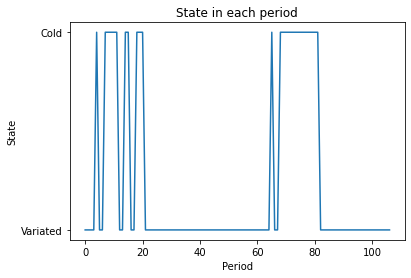

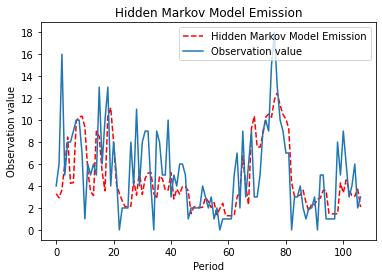

In [27]:
#Plot the state each month
plt.xlabel('Period')
plt.ylabel('State')
plt.title("State in each period")
plt.yticks([1,2,3],['Variated','Cold','Hot'])
plt.plot(range(107),poisson_hmm.decode_matrix)
plt.show()

#Plot the mu_2 each month

plt.plot(range(107),state_specific_mu,'--r',label="Hidden Markov Model Emission")


#Plot the number of strikes starting each month
plt.xlabel('Period')
plt.ylabel('Observation value')
plt.title("Hidden Markov Model Emission")
plt.plot(range(len(y)), y,label = "Observation value")
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()

**AIC**

In [28]:
-(poisson_hmm.ll_history[-1])*2+poisson_hmm.start_params.shape[0]*2

array([540.40811782])

**MAE**

In [29]:
np.abs(state_specific_mu-strikes_data['strikes']).mean()

2.260618104650052